In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

# conda install -c conda-forge fbprophet

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
n = 60
i = 1800

In [42]:
# FILE = '../../data/train_1.csv'
FILE = '/content/drive/MyDrive/Séries Temporais/Curso Fernando Amaral/train_1.csv'

all_data = pd.read_csv(FILE).T
# key = pd.read_csv('../../data/key_1.csv') # Essa base não é usada e é gigantesca. Desnecessária.

In [66]:
train, test = all_data.iloc[0:-n, :], all_data.iloc[-n:, :]

In [44]:
test_cleaned = test.T.fillna(method='ffill').T
train_cleaned = train.T.iloc[:, 1:].fillna(method='ffill').T # foward fill: assume o último valor válido

# Transpõe a tabela, de forma que as colunas sejam as datas, para que o ffill funcione. Depois transpõe de volta.

In [79]:
std_mult = 1.5

data = train_cleaned.iloc[:, 1].to_frame() # Filtra a segunda coluna do dataframe
data.columns = ['visits'] # Modifica o nome da coluna filtrada
data['mean'] = pd.Series(data['visits']).shift(1).rolling(window=50).mean() # Calcula a média móvel dos 50 dias anteriores (sem contar o próprio dia)
data['std'] = pd.Series(data['visits']).shift(1).rolling(window=50).mean() # Calcula o desvio padrão dos 50 dias anteriores (sem contar o próprio dia)
data['limit'] = std_mult * data['std'] # Define o limite
data['diff'] = np.abs(data['visits'] - data['mean']) # Calcula a diferença entre o valor atual e a média móvel
data['check'] = data['diff'] >= data['limit']
data['y'] = data.apply(lambda x: x['mean'] if x['check'] else x['visits'], axis=1) # Se o valor atual for maior que o limite, utiliza a média móvel

# Código original da aula:
# data = train_cleaned.iloc[:, 1].to_frame()
# data.columns = ['visits']
# data['mean'] = pd.Series(data['visits']).rolling(window=50).mean()
# std_mult = 1.5
# data.loc[np.abs(data['visits']-data['visits'].mean()) >= (std_mult*data['visits'].std()), 'visits'] = data.loc[np.abs(data['visits']-data['visits'].mean()) >= (std_mult*data['visits'].std()), 'mean']
# data.index = pd.to_datetime(data.index)

# Observações: 
# Nos casos em que a diferença for maior ou igual a 1.5 desvios padrão, o valor será substituído pela média móvel.
# Porém, a diferença está sendo calculada com a média geral, o que está completamente errado.
# Por isso, refiz o código da forma correta e deixei os passos mais explícitos.

In [80]:
data.head(10)

,visits,mean,std,limit,diff,check,y
2015-07-01,11.0,NaN,NaN,NaN,NaN,False,11.0
2015-07-02,14.0,NaN,NaN,NaN,NaN,False,14.0
2015-07-03,15.0,NaN,NaN,NaN,NaN,False,15.0
2015-07-04,18.0,NaN,NaN,NaN,NaN,False,18.0
2015-07-05,11.0,NaN,NaN,NaN,NaN,False,11.0
2015-07-06,13.0,NaN,NaN,NaN,NaN,False,13.0
2015-07-07,22.0,NaN,NaN,NaN,NaN,False,22.0
2015-07-08,11.0,NaN,NaN,NaN,NaN,False,11.0
2015-07-09,10.0,NaN,NaN,NaN,NaN,False,10.0
2015-07-10,4.0,NaN,NaN,NaN,NaN,False,4.0


In [81]:
data.tail(20)

,visits,mean,std,limit,diff,check,y
2016-10-13,36.0,36.12,36.12,54.18,0.12,False,36.00
2016-10-14,97.0,36.56,36.56,54.84,60.44,True,36.56
2016-10-15,179.0,38.04,38.04,57.06,140.96,True,38.04
2016-10-16,29.0,41.32,41.32,61.98,12.32,False,29.00
2016-10-17,12.0,41.66,41.66,62.49,29.66,False,12.00
2016-10-18,21.0,41.40,41.40,62.10,20.40,False,21.00
2016-10-19,42.0,41.38,41.38,62.07,0.62,False,42.00
2016-10-20,53.0,39.34,39.34,59.01,13.66,False,53.00
2016-10-21,41.0,39.78,39.78,59.67,1.22,False,41.00
2016-10-22,19.0,39.98,39.98,59.97,20.98,False,19.00


In [82]:
final_data = data['visits'].reset_index()
# final_data = data['y'].reset_index()
final_data.columns = ['ds', 'y']
final_data.head()

,ds,y
0,2015-07-01,11.0
1,2015-07-02,14.0
2,2015-07-03,15.0
3,2015-07-04,18.0
4,2015-07-05,11.0


In [83]:
m = Prophet(yearly_seasonality=True) # Assume sazonalidade anual
m.fit(final_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
future = m.make_future_dataframe(periods=n)
future.tail()

,ds
545,2016-12-27
546,2016-12-28
547,2016-12-29
548,2016-12-30
549,2016-12-31


In [85]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
545,2016-12-27,20.294940,-7.819078,47.998223
546,2016-12-28,20.540541,-7.610014,46.825417
547,2016-12-29,20.708406,-7.535178,48.330176
548,2016-12-30,21.394196,-6.780215,48.855621
549,2016-12-31,29.844379,2.387628,57.487175


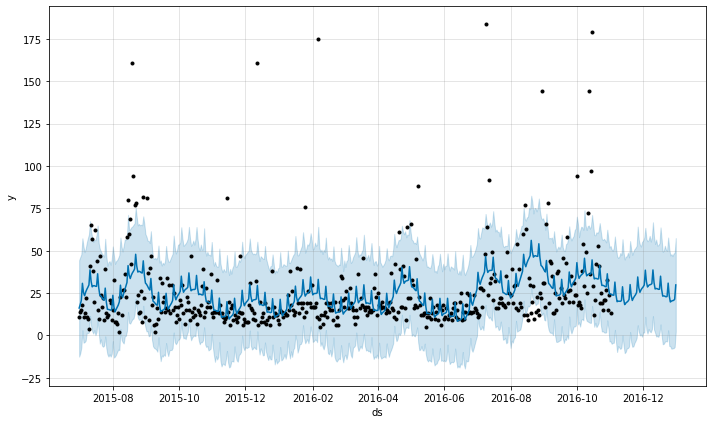

In [86]:
m.plot(forecast);

In [87]:
from sklearn.metrics import mean_absolute_error

In [88]:
real = test[1]

In [89]:
# # MAE Fernando Amaral
# pred_fernando = forecast['yhat'].tail(60)
# mae_fernando = mean_absolute_error(real, pred_fernando)
# print('MAE (Fernando Amaral): {:.2f}'.format(mae_fernando))
# MAE (Fernando Amaral): 18.38

In [90]:
# MAE Caíque Filipini
pred_caique = forecast['yhat'].tail(60)
mae_caique = mean_absolute_error(real, pred_caique)
print('MAE (Caíque Filipini): {:.2f}'.format(mae_caique))

MAE (Caíque Filipini): 21.31


Era esperado que o meu erro de fato fosse maior, visto que da forma que foi feito na aula houve vazamento de dados.